# SparkSQL y Spark DataFrames

`SparkSQL` además de permitirnos interactuar usando `SQL` (en realidad `HQL` _Hive query language_, ver documentación [aquí](https://cwiki.apache.org/confluence/display/Hive/LanguageManual)), agrega una capa de abstracción al `RDD` y lo convierte en un `DataFrame` análogo al usado en `R` y `Python`.

Como siempre, empezamos obtniendo el `SparkContext`

In [1]:
import pyspark
sc = pyspark.SparkContext('local[*]')

Pero además, obtendremos el `SQLContext` en esta ocasión

In [2]:
sqlContext = pyspark.SQLContext(sc)

## Creando un DataFrame

Ahora leeremos el archivo de transacciones creado en el laboratorio anterior

In [3]:
! ls -lh output/raw/transacciones

total 656K
-rw-r--r-- 1 jovyan users  65K Mar  1 16:34 part-00000
-rw-r--r-- 1 jovyan users  65K Mar  1 16:34 part-00001
-rw-r--r-- 1 jovyan users  65K Mar  1 16:34 part-00002
-rw-r--r-- 1 jovyan users 129K Mar  1 16:34 part-00003
-rw-r--r-- 1 jovyan users  65K Mar  1 16:34 part-00004
-rw-r--r-- 1 jovyan users  65K Mar  1 16:34 part-00005
-rw-r--r-- 1 jovyan users  65K Mar  1 16:34 part-00006
-rw-r--r-- 1 jovyan users 115K Mar  1 16:34 part-00007
-rw-r--r-- 1 jovyan users    0 Mar  1 16:34 _SUCCESS


**NOTA**: Si marca error la última instrucción, regresa al laboratorio anterior y crea de nuevo el archivo.

In [4]:
txs_rdd = sc.textFile("output/raw/transacciones")

In [5]:
txs_rdd.first()

'52778545-1a96-4550-a9b4-f666218925a0|SUPERCITO|RETIRO|4195'

Para poder obtener un `DataFrame` hay que extraer cada línea del `RDD` a un objeto `Row`

In [6]:
from pyspark.sql import Row

In [7]:
Transaccion = Row('tdc', 'comercio', 'accion', 'monto')

In [8]:
def getTransaccion(linea):
    cells = linea.split('|')
    cells[3] = int(cells[3])
    return Transaccion(*cells)

In [9]:
txs = txs_rdd.map(getTransaccion)

In [10]:
txs.first()

Row(tdc='52778545-1a96-4550-a9b4-f666218925a0', comercio='SUPERCITO', accion='RETIRO', monto=4195)

In [11]:
txs_df = txs.toDF()

In [12]:
txs_df

DataFrame[tdc: string, comercio: string, accion: string, monto: bigint]

In [13]:
txs

PythonRDD[9] at RDD at PythonRDD.scala:43

In [14]:
txs_df.printSchema()

root
 |-- tdc: string (nullable = true)
 |-- comercio: string (nullable = true)
 |-- accion: string (nullable = true)
 |-- monto: long (nullable = true)



In [15]:
txs_df.show()

+--------------------+--------------------+------+-----+
|                 tdc|            comercio|accion|monto|
+--------------------+--------------------+------+-----+
|52778545-1a96-455...|           SUPERCITO|RETIRO| 4195|
|e90e5523-50fc-42a...|RESTAURANTE EL TR...|COMPRA| 4763|
|52778545-1a96-455...|           SUPERCITO|RETIRO| 5728|
|8a7338f8-37b3-46e...|           SUPERCITO|RETIRO| 5723|
|52778545-1a96-455...|           SUPERCITO|RETIRO| 1731|
|e90e5523-50fc-42a...|       ARENA COLISEO|RETIRO| 7457|
|e90e5523-50fc-42a...|       ARENA COLISEO|RETIRO| 3227|
|2033ac7f-9f9b-424...|RESTAURANTE EL TR...|RETIRO|  701|
|8a7338f8-37b3-46e...|       ARENA COLISEO|COMPRA| 6172|
|2033ac7f-9f9b-424...|RESTAURANTE EL TR...|RETIRO| 4105|
|52778545-1a96-455...|           SUPERCITO|RETIRO| 8051|
|5d88e1a3-ca7c-4ed...|RESTAURANTE EL TR...|RETIRO| 3212|
|e90e5523-50fc-42a...|       ARENA COLISEO|COMPRA| 9162|
|e90e5523-50fc-42a...|       ARENA COLISEO|COMPRA| 7259|
|8a7338f8-37b3-46e...|       AR

## Registrando una tabla

Al tener un `DataFrame` es posible usar la `API` o usar `SQL`. Para mostrarlo, primero registremos la tabla

In [16]:
txs_df.registerTempTable('txs')

In [17]:
sqlContext.sql("show tables").show()

+---------+-----------+
|tableName|isTemporary|
+---------+-----------+
|      txs|       true|
+---------+-----------+



In [18]:
sqlContext.sql("select * from txs limit 5").show()

+--------------------+--------------------+------+-----+
|                 tdc|            comercio|accion|monto|
+--------------------+--------------------+------+-----+
|52778545-1a96-455...|           SUPERCITO|RETIRO| 4195|
|e90e5523-50fc-42a...|RESTAURANTE EL TR...|COMPRA| 4763|
|52778545-1a96-455...|           SUPERCITO|RETIRO| 5728|
|8a7338f8-37b3-46e...|           SUPERCITO|RETIRO| 5723|
|52778545-1a96-455...|           SUPERCITO|RETIRO| 1731|
+--------------------+--------------------+------+-----+



Ahora que `txs` ya tiene esquema, es buena idea guardarlo

In [19]:
sqlContext.sql("select * from txs")\
          .coalesce(1)\
          .write.format("parquet")\
          .save("output/parquet/transacciones", mode="OVERWRITE")

In [20]:
sqlContext.sql("select * from txs")\
          .coalesce(1)\
          .write.format("json")\
          .save("output/json/transacciones", mode="OVERWRITE")

In [21]:
! head -2 output/json/transacciones/part-r-00000-a2cf4d62-b13c-4f61-a492-6fb88afe0471

head: cannot open ‘output/json/transacciones/part-r-00000-a2cf4d62-b13c-4f61-a492-6fb88afe0471’ for reading: No such file or directory


 ## Usando la API

Al igual que los `RDD`s, los `DataFrames` pueden ser operados mediante _transformaciones_ y _acciones_. Las **Transformaciones** son _lazy_ pero contribuyen a la planeación de la ejecución del _query_, las **Acciones** provocan la ejecución del _query_

### Transformaciones

- `filter`
- `select`
- `drop`
- `join`

### Acciones

- `count`
- `collect`
- `show`
- `head`
- `take`

# Código Escala

In [22]:
txs_df.select(txs_df['tdc'], txs_df['accion'], txs_df['monto'], txs_df['monto'] >= 5000).show(5)

+--------------------+------+-----+---------------+
|                 tdc|accion|monto|(monto >= 5000)|
+--------------------+------+-----+---------------+
|52778545-1a96-455...|RETIRO| 4195|          false|
|e90e5523-50fc-42a...|COMPRA| 4763|          false|
|52778545-1a96-455...|RETIRO| 5728|           true|
|8a7338f8-37b3-46e...|RETIRO| 5723|           true|
|52778545-1a96-455...|RETIRO| 1731|          false|
+--------------------+------+-----+---------------+
only showing top 5 rows



In [23]:
sqlContext.sql("select tdc, accion, monto, monto >= 5000 from txs").show(5)

+--------------------+------+-----+-----+
|                 tdc|accion|monto|  _c3|
+--------------------+------+-----+-----+
|52778545-1a96-455...|RETIRO| 4195|false|
|e90e5523-50fc-42a...|COMPRA| 4763|false|
|52778545-1a96-455...|RETIRO| 5728| true|
|8a7338f8-37b3-46e...|RETIRO| 5723| true|
|52778545-1a96-455...|RETIRO| 1731|false|
+--------------------+------+-----+-----+
only showing top 5 rows



In [24]:
txs_df.filter((txs_df["monto"] >= 5000) & (txs_df["accion"] == "RETIRO"))\
      .select(txs_df["tdc"], txs_df["comercio"], txs_df["monto"])\
      .orderBy(txs_df["monto"].desc())\
      .show(5)

+--------------------+--------------------+-----+
|                 tdc|            comercio|monto|
+--------------------+--------------------+-----+
|5d88e1a3-ca7c-4ed...|       ARENA COLISEO|10000|
|52778545-1a96-455...|           SUPERCITO|10000|
|8a7338f8-37b3-46e...|RESTAURANTE EL TR...| 9999|
|e90e5523-50fc-42a...|           SUPERCITO| 9997|
|5d88e1a3-ca7c-4ed...|           SUPERCITO| 9997|
+--------------------+--------------------+-----+
only showing top 5 rows



**NOTA**: `where()` es un _alias_ para `filter()`

In [25]:
txs_df.where((txs_df["monto"] >= 5000) & (txs_df["accion"] == "RETIRO"))\
      .select(txs_df["tdc"], txs_df["comercio"], txs_df["monto"])\
      .show(5)

+--------------------+--------------------+-----+
|                 tdc|            comercio|monto|
+--------------------+--------------------+-----+
|52778545-1a96-455...|           SUPERCITO| 5728|
|8a7338f8-37b3-46e...|           SUPERCITO| 5723|
|e90e5523-50fc-42a...|       ARENA COLISEO| 7457|
|52778545-1a96-455...|           SUPERCITO| 8051|
|52778545-1a96-455...|RESTAURANTE EL TR...| 7206|
+--------------------+--------------------+-----+
only showing top 5 rows



También es posible usar `strings` para el condicional

In [26]:
txs_df.filter("monto >= 5000 and accion = 'RETIRO'")\
      .select(txs_df["tdc"], txs_df["comercio"], txs_df["monto"])\
      .orderBy(txs_df["monto"].asc())\
      .show(5)

+--------------------+--------------------+-----+
|                 tdc|            comercio|monto|
+--------------------+--------------------+-----+
|e90e5523-50fc-42a...|           SUPERCITO| 5006|
|2033ac7f-9f9b-424...|RESTAURANTE EL TR...| 5009|
|52778545-1a96-455...|RESTAURANTE EL TR...| 5009|
|5d88e1a3-ca7c-4ed...|           SUPERCITO| 5009|
|5d88e1a3-ca7c-4ed...|       ARENA COLISEO| 5009|
+--------------------+--------------------+-----+
only showing top 5 rows



In [27]:
txs_df.groupBy("tdc").count().show(5)

+--------------------+-----+
|                 tdc|count|
+--------------------+-----+
|8a7338f8-37b3-46e...| 1989|
|e90e5523-50fc-42a...| 2028|
|5d88e1a3-ca7c-4ed...| 1964|
|2033ac7f-9f9b-424...| 1987|
|52778545-1a96-455...| 2032|
+--------------------+-----+



In [28]:
txs_df.groupBy("tdc").count().show(5)

+--------------------+-----+
|                 tdc|count|
+--------------------+-----+
|8a7338f8-37b3-46e...| 1989|
|e90e5523-50fc-42a...| 2028|
|5d88e1a3-ca7c-4ed...| 1964|
|2033ac7f-9f9b-424...| 1987|
|52778545-1a96-455...| 2032|
+--------------------+-----+



### User Defined Functions: UDF

Supongamos que queremos mostrar el  `tdc` en mayúsculas, para tal menester es necesario definir una `UDF`

In [29]:
from pyspark.sql.functions import udf
to_upper = udf(lambda s: s.upper())


In [30]:
txs_df.select(to_upper(txs_df["tdc"]).alias("Mayúsculas"), txs_df["tdc"])\
      .distinct()\
      .show(100)

+--------------------+--------------------+
|          Mayúsculas|                 tdc|
+--------------------+--------------------+
|E90E5523-50FC-42A...|e90e5523-50fc-42a...|
|2033AC7F-9F9B-424...|2033ac7f-9f9b-424...|
|8A7338F8-37B3-46E...|8a7338f8-37b3-46e...|
|52778545-1A96-455...|52778545-1a96-455...|
|5D88E1A3-CA7C-4ED...|5d88e1a3-ca7c-4ed...|
+--------------------+--------------------+



Imaginemos que sólo estamos interesados en aquellas transacciones que fueron `RETIRO`s en el `SUPERCITO` por montos mayores a `9000` ya que resultan sospechosos.

In [31]:
txs_sospechosas = txs_df.filter("monto >= 9000 and accion = 'RETIRO' and comercio = 'SUPERCITO'")\
      .select(txs_df["tdc"],  txs_df["monto"])\
      .orderBy(txs_df["monto"].desc())

In [32]:
txs_sospechosas.count()

170

Guardemos la información para un posterior análisis

In [33]:
txs_sospechosas.coalesce(1)\
               .write.format("json")\
               .save("output/json/transacciones_sospechosas", mode="OVERWRITE")

In [34]:
txs_sospechosas.coalesce(1)\
               .write.format("parquet")\
               .save("output/parquet/transacciones_sospechosas", mode="OVERWRITE")

In [35]:
! ls -lh output/json/transacciones_sospechosas

total 12K
-rw-r--r-- 1 jovyan users 10K Mar  1 16:52 part-r-00000-8d332f39-45c3-4e86-8024-33cf002db23c
-rw-r--r-- 1 jovyan users   0 Mar  1 16:52 _SUCCESS


## DataFrame desde JSON

Para esta sección usaremos los datos de proyectos soportados por el **Banco Mundial**

In [36]:
!ls -al data/

total 36
drwxrwxrwx 4 root   root   4096 Mar  1 16:50 .
drwxrwxrwx 6 root   root   4096 Mar  1 16:51 ..
drwxr-xr-x 2 root   root   4096 Mar  1 14:25 books
-rw-r--r-- 1 root   root  19910 Mar  1 14:25 log_datos.dat
drwxr-xr-x 2 jovyan users  4096 Mar  1 16:50 world_bank


In [37]:
! rm -R data/world_bank*

In [38]:
! wget http://jsonstudio.com/wp-content/uploads/2014/02/world_bank.zip -P data/

--2016-03-01 16:52:42--  http://jsonstudio.com/wp-content/uploads/2014/02/world_bank.zip
Resolving jsonstudio.com (jsonstudio.com)... 104.238.96.73
Connecting to jsonstudio.com (jsonstudio.com)|104.238.96.73|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 446064 (436K) [application/zip]
Saving to: ‘data/world_bank.zip’

data/world_bank.zip 100%[=====================>] 435.61K   446KB/s   in 1.0s   

2016-03-01 16:52:44 (446 KB/s) - ‘data/world_bank.zip’ saved [446064/446064]



In [39]:
! unzip data/world_bank.zip -d data/world_bank

Archive:  data/world_bank.zip
  inflating: data/world_bank/world_bank.json  


In [40]:
! rm data/world_bank.zip

Creamos el `DataFrame`

In [41]:
world_bank = sqlContext.read.json("data/world_bank/world_bank.json")

Automáticamente detecta el _esquema_ de la fuente de datos

In [42]:
world_bank.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- $oid: string (nullable = true)
 |-- approvalfy: string (nullable = true)
 |-- board_approval_month: string (nullable = true)
 |-- boardapprovaldate: string (nullable = true)
 |-- borrower: string (nullable = true)
 |-- closingdate: string (nullable = true)
 |-- country_namecode: string (nullable = true)
 |-- countrycode: string (nullable = true)
 |-- countryname: string (nullable = true)
 |-- countryshortname: string (nullable = true)
 |-- docty: string (nullable = true)
 |-- envassesmentcategorycode: string (nullable = true)
 |-- grantamt: long (nullable = true)
 |-- ibrdcommamt: long (nullable = true)
 |-- id: string (nullable = true)
 |-- idacommamt: long (nullable = true)
 |-- impagency: string (nullable = true)
 |-- lendinginstr: string (nullable = true)
 |-- lendinginstrtype: string (nullable = true)
 |-- lendprojectcost: long (nullable = true)
 |-- majorsector_percent: array (nullable = true)
 |    |-- element: struct (containsNu

La estructura es anidada (en lugar de bidimensional), pero observa que `Spark` no tuvo ningún problema.

In [43]:
world_bank.registerTempTable("world_bank_projects")

In [44]:
sqlContext.sql('show tables').show()

+-------------------+-----------+
|          tableName|isTemporary|
+-------------------+-----------+
|world_bank_projects|       true|
|                txs|       true|
+-------------------+-----------+



In [45]:
sqlContext.sql('select countryshortname, project_name, totalamt, totalcommamt from world_bank_projects order by countryshortname').show()

+----------------+--------------------+---------+------------+
|countryshortname|        project_name| totalamt|totalcommamt|
+----------------+--------------------+---------+------------+
|     Afghanistan|Afghanistan Agric...|        0|    74730000|
|     Afghanistan|Afghanistan: Syst...|100000000|   100000000|
|     Afghanistan|Afghanistan: Safe...| 12500000|    12500000|
|     Afghanistan|Afghanistan - Sec...| 55000000|    55000000|
|     Afghanistan|AF: Development P...| 50000000|    50000000|
|     Afghanistan|Afghanistan: Nati...|        0|   100000000|
|          Africa|Southern Africa T...|213000000|   213000000|
|          Africa|West Africa  Regi...|        0|    10000000|
|          Africa|Agricultural Prod...| 90000000|    90000000|
|          Africa|Fighting against ...|        0|     2000000|
|          Africa|Additional Financ...| 60000000|    60000000|
|          Africa|Regional Rusumo F...|339900000|   339900000|
|          Africa|First Part of the...|203000000|   203

In [46]:
projects_by_country = sqlContext.sql('select countryshortname as country, count(project_name) as num_projects, sum(totalamt) as total_amount from world_bank_projects group by countryshortname order by total_amount desc')
projects_by_country.show()

+--------------------+------------+------------+
|             country|num_projects|total_amount|
+--------------------+------------+------------+
|               India|          16|  2595700000|
|              Brazil|           9|  2326200000|
|           Indonesia|          19|  2045500000|
|             Vietnam|          17|  1832400000|
|          Bangladesh|          12|  1566500000|
|               China|          19|  1540000000|
|              Poland|           1|  1307800000|
|              Turkey|           4|  1301000000|
|            Ethiopia|           4|  1245000000|
|             Nigeria|           7|  1220000000|
|              Africa|          11|   987900000|
|            Colombia|           3|   950000000|
|               Kenya|           6|   875000000|
|             Morocco|          12|   793200000|
|            Pakistan|           9|   744000000|
|             Myanmar|           3|   660000000|
|          Mozambique|          11|   657000000|
|            Tanzani

Una pregunta válida es ¿Cómo leo lo anidado en un `json` (es decir un objeto `struct`)? ¿Y si hay arreglos (es decir un objeto `array`)?

Para el primer caso, debes de usar el operador de *acces*, i.e. el operador `.` (si estás viendo bien, es un punto):

In [ ]:
# Estoy usando `toPandas` para que se vea bonito en *Jupyter*
# Eso lo explicaré en la siguiente sección
sqlContext.sql("select theme1, theme1.Name, theme1.Percent from world_bank_projects limit 10").toPandas()

Para el caso de un arreglo, no tenemos nada en nuestra fuente de datos así, más bien tenemos el caso más complicado de un arreglo (`array`) con una estructura (`struct`) adentro.

En `SQL` se arregla con un `LATERAL VIEW`

```
sqlContext.sql("select expSector.Name from world_bank_projects LATERAL VIEW explode(sector) t AS expSector").collect().foreach(println)
```

Pero esto sólo funciona cuando estamos pegados a `Hive` y eso será hasta que tengamos un _cluster_ `:(`


Pero, podemos usar el **API** de `Spark SQL`:

In [ ]:
from pyspark.sql.functions import explode

In [ ]:
wb_df = sqlContext.sql("select * from world_bank_projects")

Para eso usaremos la función `explode()`. Esta función _explota_ el arreglo devolviendo una línea por cada elemento del mismo:

In [ ]:
# De nuevo estoy usando `toPandas` para que se vea bonito en *Jupyter*
wb_df.select(wb_df["countryshortname"].alias('country'), wb_df["sector"].alias("sector"))\
     .where("country = 'Mexico'").toPandas()

Si usamos `explode` observa lo que pasa:

In [ ]:
# De nuevo estoy usando `toPandas` para que se vea bonito en *Jupyter*
wb_df.select(wb_df["countryshortname"].alias('country'), explode(wb_df["sector"]).alias("sector"))\
     .where("country = 'Mexico'").toPandas()

Como mencioné nuestra base de datos tiene un `array`de `structs`, por lo tanto hay que hacer **dos** `selects`: uno para _explotar_ (con `explode`) y otro para _extraer_ (con el operador `.`)

In [ ]:
# De nuevo estoy usando `toPandas` para que se vea bonito en *Jupyter*
wb_df.select(wb_df["countryshortname"].alias('country'), explode(wb_df["sector"]).alias("sector"))\
     .select("country", "sector.Name").where("country = 'Mexico'").toPandas()

## SparkSQL y Pandas

Es posible usar `Pandas` para hacer análisis, pero hay que tomar en cuenta que esto manda _todo_ el `dataset` a un sólo nodo.

**NOTA** Aquí explicaré el `toPandas()` usado en la sección anterior...

In [47]:
import pandas as pd

In [48]:
projects_by_country_pd = projects_by_country.toPandas()

In [49]:
projects_by_country_pd.columns

Index(['country', 'num_projects', 'total_amount'], dtype='object')

In [50]:
projects_by_country_pd=projects_by_country_pd.set_index(['country'])

In [51]:
projects_by_country_pd.num_projects

country
India                            16
Brazil                            9
Indonesia                        19
Vietnam                          17
Bangladesh                       12
China                            19
Poland                            1
Turkey                            4
Ethiopia                          4
Nigeria                           7
Africa                           11
Colombia                          3
Kenya                             6
Morocco                          12
Pakistan                          9
Myanmar                           3
Mozambique                       11
Tanzania                          8
Egypt, Arab Republic of           2
Tunisia                           4
Ukraine                           4
Congo, Democratic Republic of     6
Philippines                       3
Uruguay                           3
Croatia                           4
Burkina Faso                      9
Nepal                            12
Uzbekistan          

In [52]:
projects_by_country_pd.head()

,num_projects,total_amount
country,,
India,16,2595700000
Brazil,9,2326200000
Indonesia,19,2045500000
Vietnam,17,1832400000
Bangladesh,12,1566500000


In [53]:
projects_by_country_pd.ix['Peru']

num_projects            6
total_amount    125000000
Name: Peru, dtype: int64

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


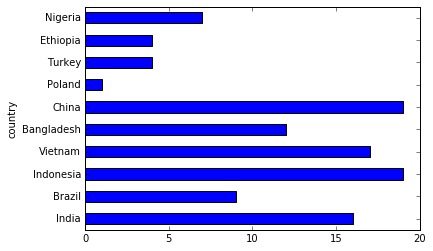

In [54]:
%pylab inline
projects_by_country_pd['num_projects'][:10].plot(kind='barh', rot=0, )